# Anàlisis del retràs dels trens polonesos
## Treball cas Kaggle
##### Catalina Mascaró Català - 1708159 i Mathilde - [Pon tu NIU]

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV, KFold

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline

from matplotlib.gridspec import GridSpec
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, precision_score, recall_score, roc_curve, auc, precision_recall_curve, classification_report, average_precision_score

from time import time
from scipy.interpolate import splrep, BSpline

%matplotlib inline

In [50]:
df = pd.read_csv('./train_delay_data.csv') # Dataset descarregat desde https://www.kaggle.com/datasets/ravisingh0399/train-delay-dataset

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2878 entries, 0 to 2877
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Distance Between Stations (km)  2878 non-null   int64 
 1   Weather Conditions              2878 non-null   object
 2   Day of the Week                 2878 non-null   object
 3   Time of Day                     2878 non-null   object
 4   Train Type                      2878 non-null   object
 5   Historical Delay (min)          2878 non-null   int64 
 6   Route Congestion                2878 non-null   object
dtypes: int64(2), object(5)
memory usage: 157.5+ KB


In [52]:
df.head()

,Distance Between Stations (km),Weather Conditions,Day of the Week,Time of Day,Train Type,Historical Delay (min),Route Congestion
0,100,Clear,Monday,Morning,Express,5,Low
1,150,Rainy,Tuesday,Afternoon,Superfast,10,Medium
2,200,Foggy,Wednesday,Evening,Local,15,High
3,50,Clear,Thursday,Night,Express,2,Low
4,75,Rainy,Friday,Morning,Superfast,8,Medium


In [53]:
df.describe()

,Distance Between Stations (km),Historical Delay (min)
count,2878.000000,2878.000000
mean,184.423211,93.324878
std,169.394783,195.923817
min,0.000000,0.000000
25%,70.000000,13.000000
50%,155.000000,35.000000
75%,225.000000,74.000000
max,955.000000,1230.000000


Veiem que la nostra base de dades no té dades faltants o incompletes. Les columnes "Distance Between Stations (km)" i "Historical Delay (min)" són integers, mentre que la resta són variables categòriques.

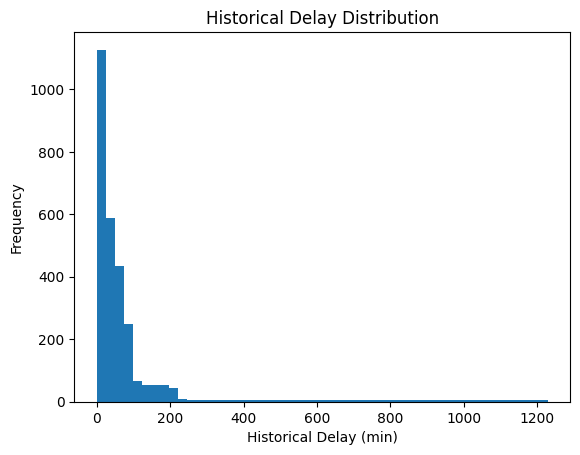

In [54]:
df["Historical Delay (min)"].plot(kind='hist', bins=50, title='Historical Delay Distribution')
plt.xlabel('Historical Delay (min)')
plt.show()

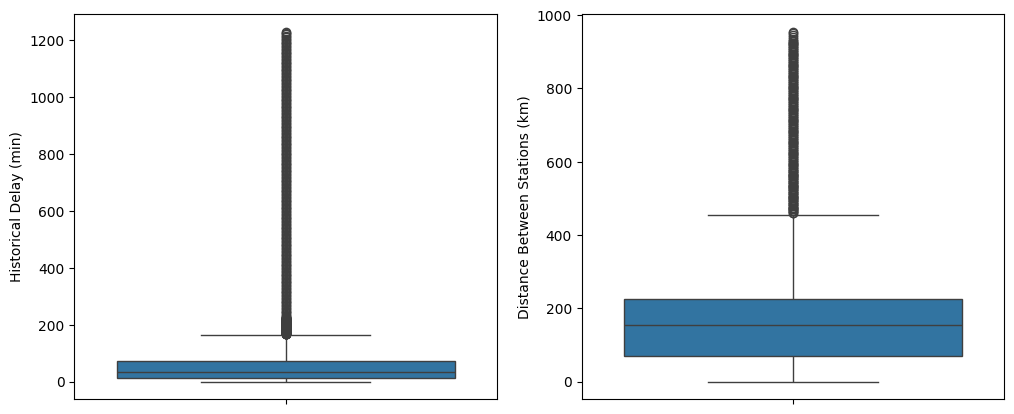

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y='Historical Delay (min)', data=df, ax=axes[0])
sns.boxplot(y='Distance Between Stations (km)', data=df, ax=axes[1])
plt.show()

Decidim convertir les variables categòriques "Weather Conditions", "Day of the Week", "Time of Day" i "Train Type" en un conjunt de variables binàries equivalent. A més, la variable "Route Congestion", que és categòrica però ordenada, la substituïm per valors numerics: 1-low, 2-medium, 3-high.

Observant la distribució de la variable objectiu ("Historical Delay (min)"), veiem que té valors molt dispars, (fins unes 22h de retràs). Davant això, decidim fer un primer model classificador per separar les dades que tenen molt retràs, i les que en tenen poc. Agafem un llindar de 60 min com a frontera observant el gràfic, però amb més dades es podria ajustar aquest valor en forma d'hiperparàmetre. Sobre els dos grups, aplicarem tècniques de regressió per predir el retràs dels trens.

Per tant, afegim una variable anomenada "Delay", que servirà com a variable objectiu del primer classificador.

In [56]:
weather = pd.get_dummies(df['Weather Conditions'],drop_first=True)
days = pd.get_dummies(df['Day of the Week'],drop_first=True)
time = pd.get_dummies(df['Time of Day'], drop_first=True)
train = pd.get_dummies(df['Train Type'], drop_first=True)
df['congest'] = pd.Categorical(
    df['Route Congestion'],
    categories=['Low', 'Medium', 'High'],
    ordered=True
)

df['congest'] = df['congest'].cat.codes + 1
delay = df['Historical Delay (min)'].apply(lambda x: 1 if x > 60 else 0)
delay.name = 'Delay' #0: Poco Delay, 1: Delay > 60 mins

df.drop(['Weather Conditions','Day of the Week','Time of Day','Train Type','Route Congestion'],axis=1,inplace=True) 
df = pd.concat([df,weather,days,time,train, delay],axis=1) 
df.head()

,Distance Between Stations (km),Historical Delay (min),congest,Foggy,Rainy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Evening,Morning,Night,Local,Superfast,Delay
0,100,5,1,False,False,True,False,False,False,False,False,False,True,False,False,False,0
1,150,10,2,False,True,False,False,False,False,True,False,False,False,False,False,True,0
2,200,15,3,True,False,False,False,False,False,False,True,True,False,False,True,False,0
3,50,2,1,False,False,False,False,False,True,False,False,False,False,True,False,False,0
4,75,8,2,False,True,False,False,False,False,False,False,False,True,False,False,True,0


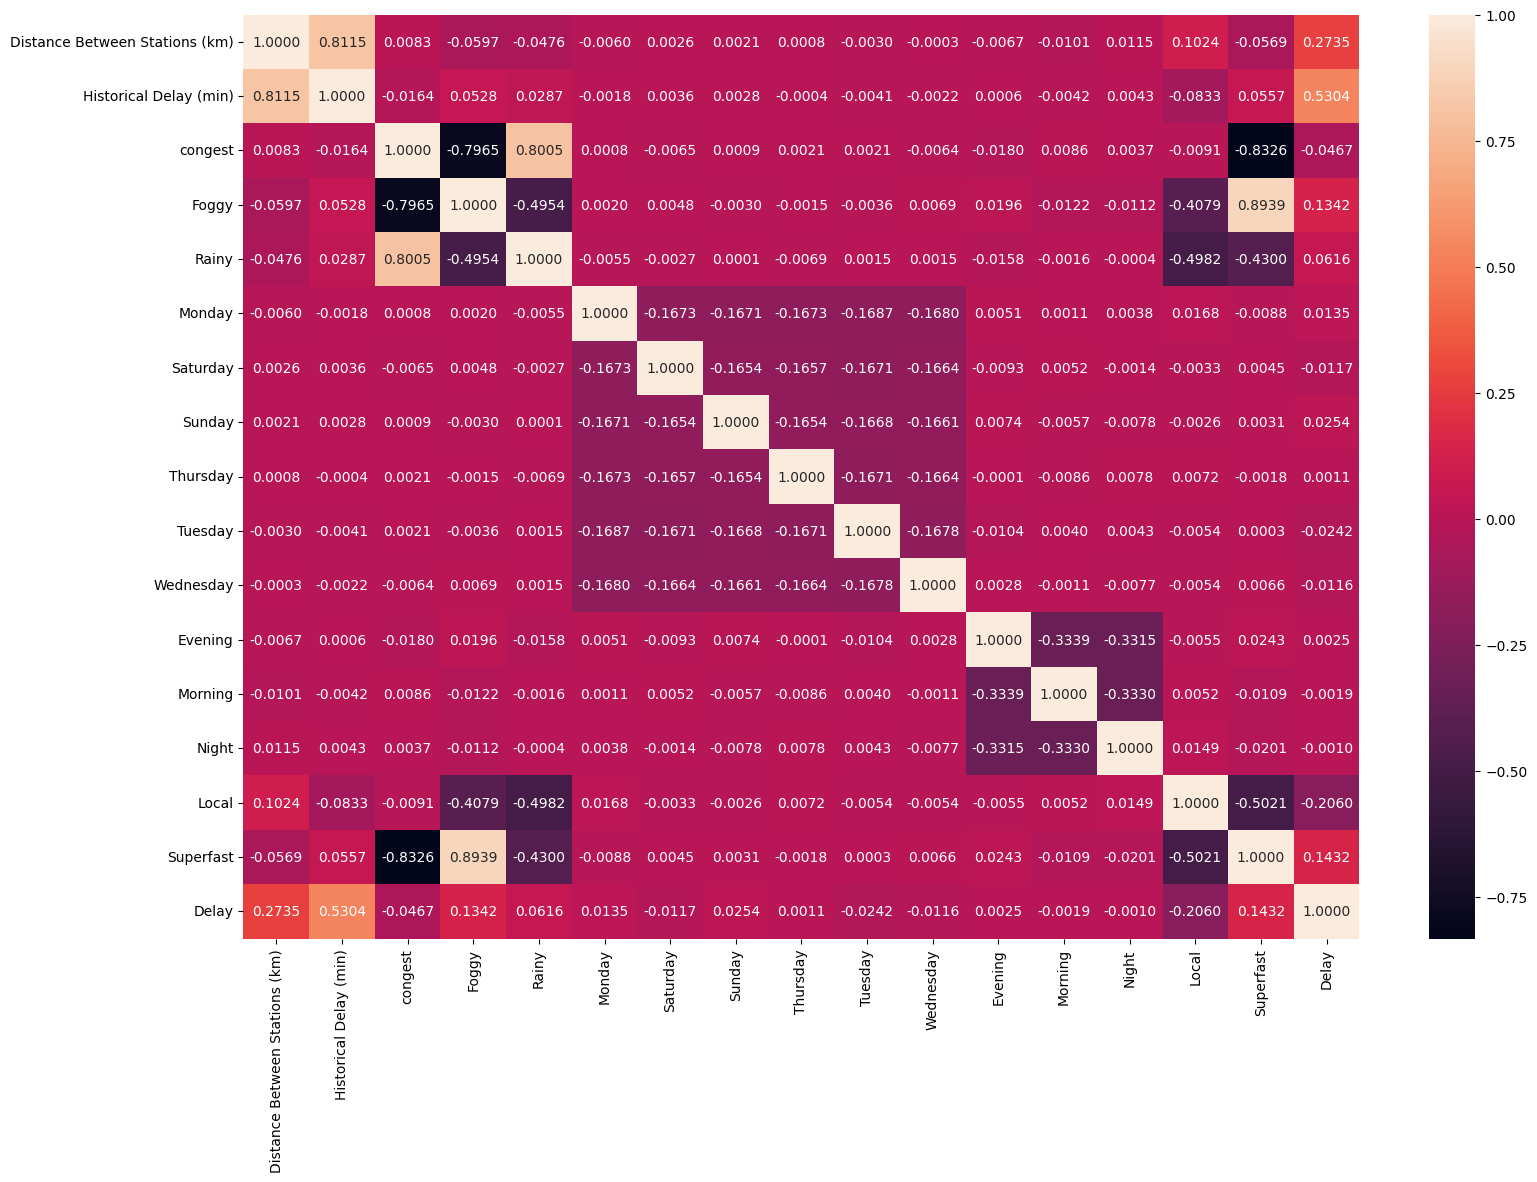

In [57]:
# Mirem les correlacions entre les variables
plt.figure(figsize=(18, 12))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".4f")
plt.show()

c:\Users\Usuari\Documents\uni\3r\Aprenentatge computacional\Kaggle\.venv\Lib\site-packages\matplotlib\axes\_axes.py:7132: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


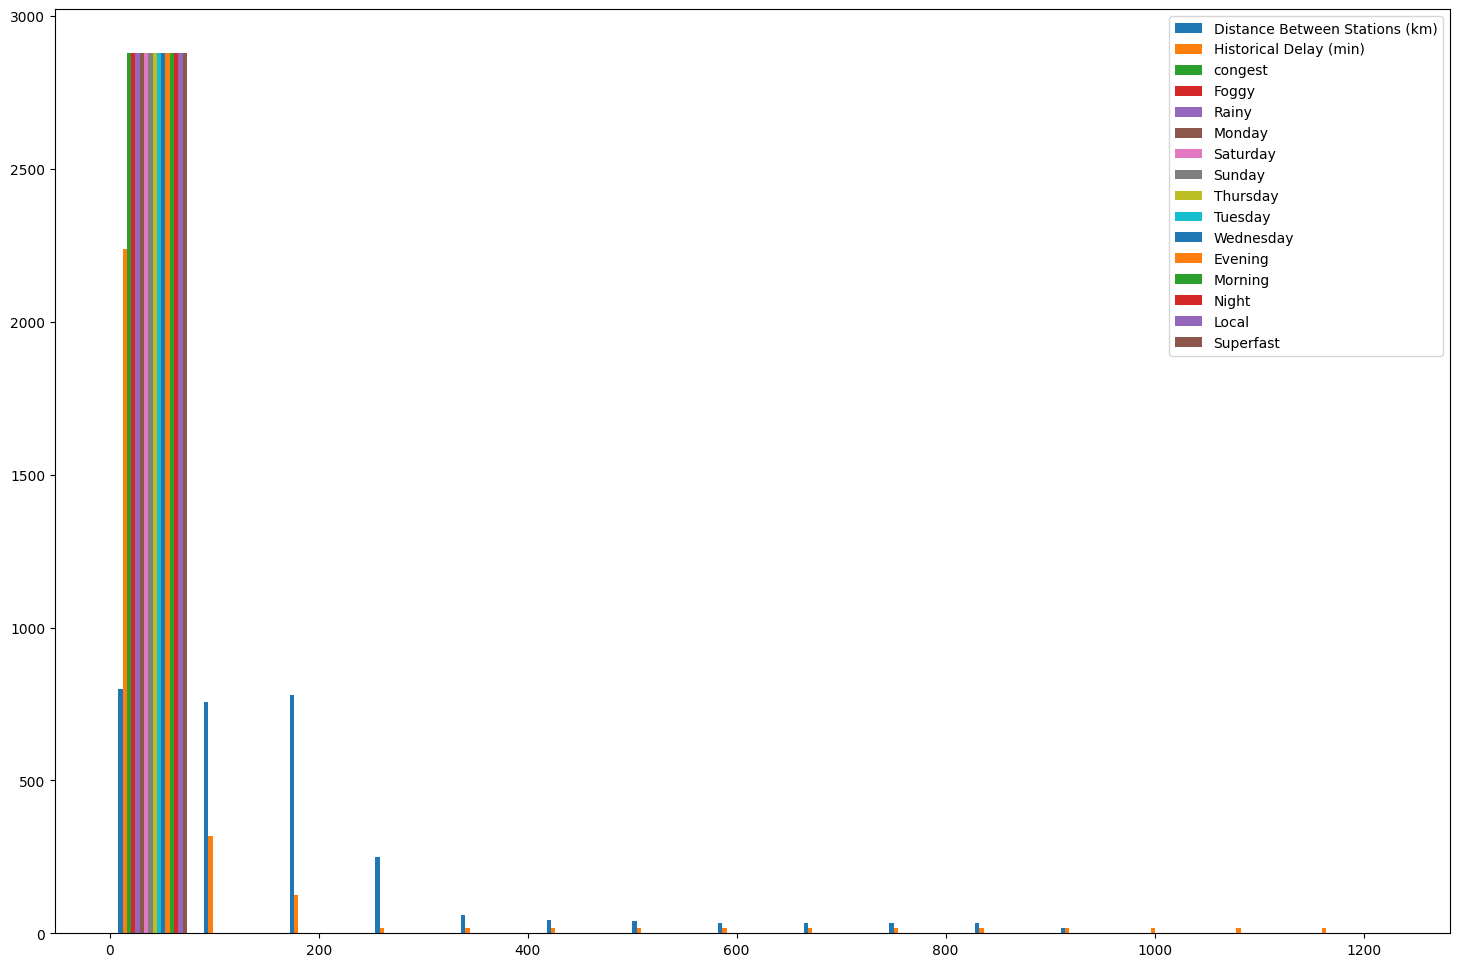

In [58]:
plt.figure(figsize=(18, 12))
plt.hist([df[c] for c in df.columns][:16], bins=15, label=[c for c in df.columns][:16])
plt.legend()
plt.show()

En aquest punt, decidim normalitzar les dades enteres, "Distance Between Stations (km)" i "Historical Delay (min)". Hem de tenir en compte que estem normalitzant també la variable objectiu, per això no eliminem les variables originals, ja que al final voldrem comparar el resultat del nostre model (en minuts, és a dir, amb una transformació inversa) amb el retràs original. Durant el procès, ignorarem les variables no normalitzades.

c:\Users\Usuari\Documents\uni\3r\Aprenentatge computacional\Kaggle\.venv\Lib\site-packages\matplotlib\axes\_axes.py:7132: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


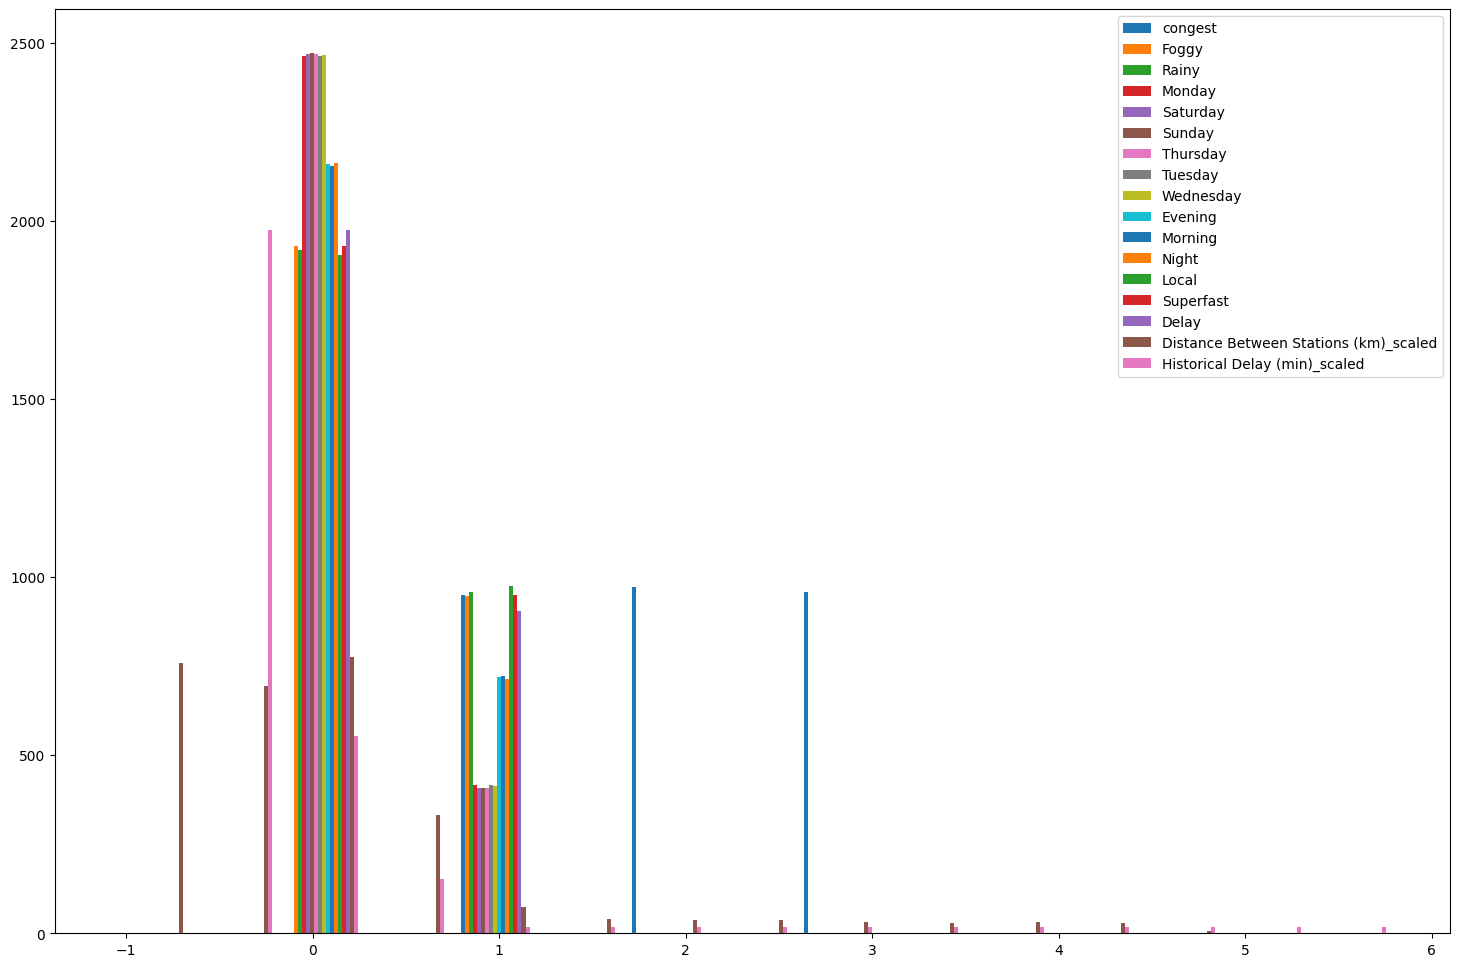

,Distance Between Stations (km),Historical Delay (min),congest,Foggy,Rainy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Evening,Morning,Night,Local,Superfast,Delay,Distance Between Stations (km)_scaled,Historical Delay (min)_scaled
0,100,5,1,False,False,True,False,False,False,False,False,False,True,False,False,False,0,-0.498468,-0.450891
1,150,10,2,False,True,False,False,False,False,True,False,False,False,False,False,True,0,-0.203248,-0.425366
2,200,15,3,True,False,False,False,False,False,False,True,True,False,False,True,False,0,0.091972,-0.399842
3,50,2,1,False,False,False,False,False,True,False,False,False,False,True,False,False,0,-0.793688,-0.466205
4,75,8,2,False,True,False,False,False,False,False,False,False,True,False,False,True,0,-0.646078,-0.435576


In [59]:
scaler = StandardScaler()
columnes = ['Distance Between Stations (km)', 'Historical Delay (min)'] # les columnes que volem escalar
for col in columnes:
    df[f'{col}_scaled'] = scaler.fit_transform(df[[col]])



# Visualització
plt.figure(figsize=(18, 12))
plt.hist([df[c] for c in df.columns][2:19], bins=15, label=[c for c in df.columns][2:19])
plt.legend()
plt.show()
df.head()

In [60]:
df['weekend'] = df['Saturday'] | df['Sunday']
df.drop(['Monday','Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday'],axis=1,inplace=True)
df.drop(['Evening','Morning'],axis=1,inplace=True)

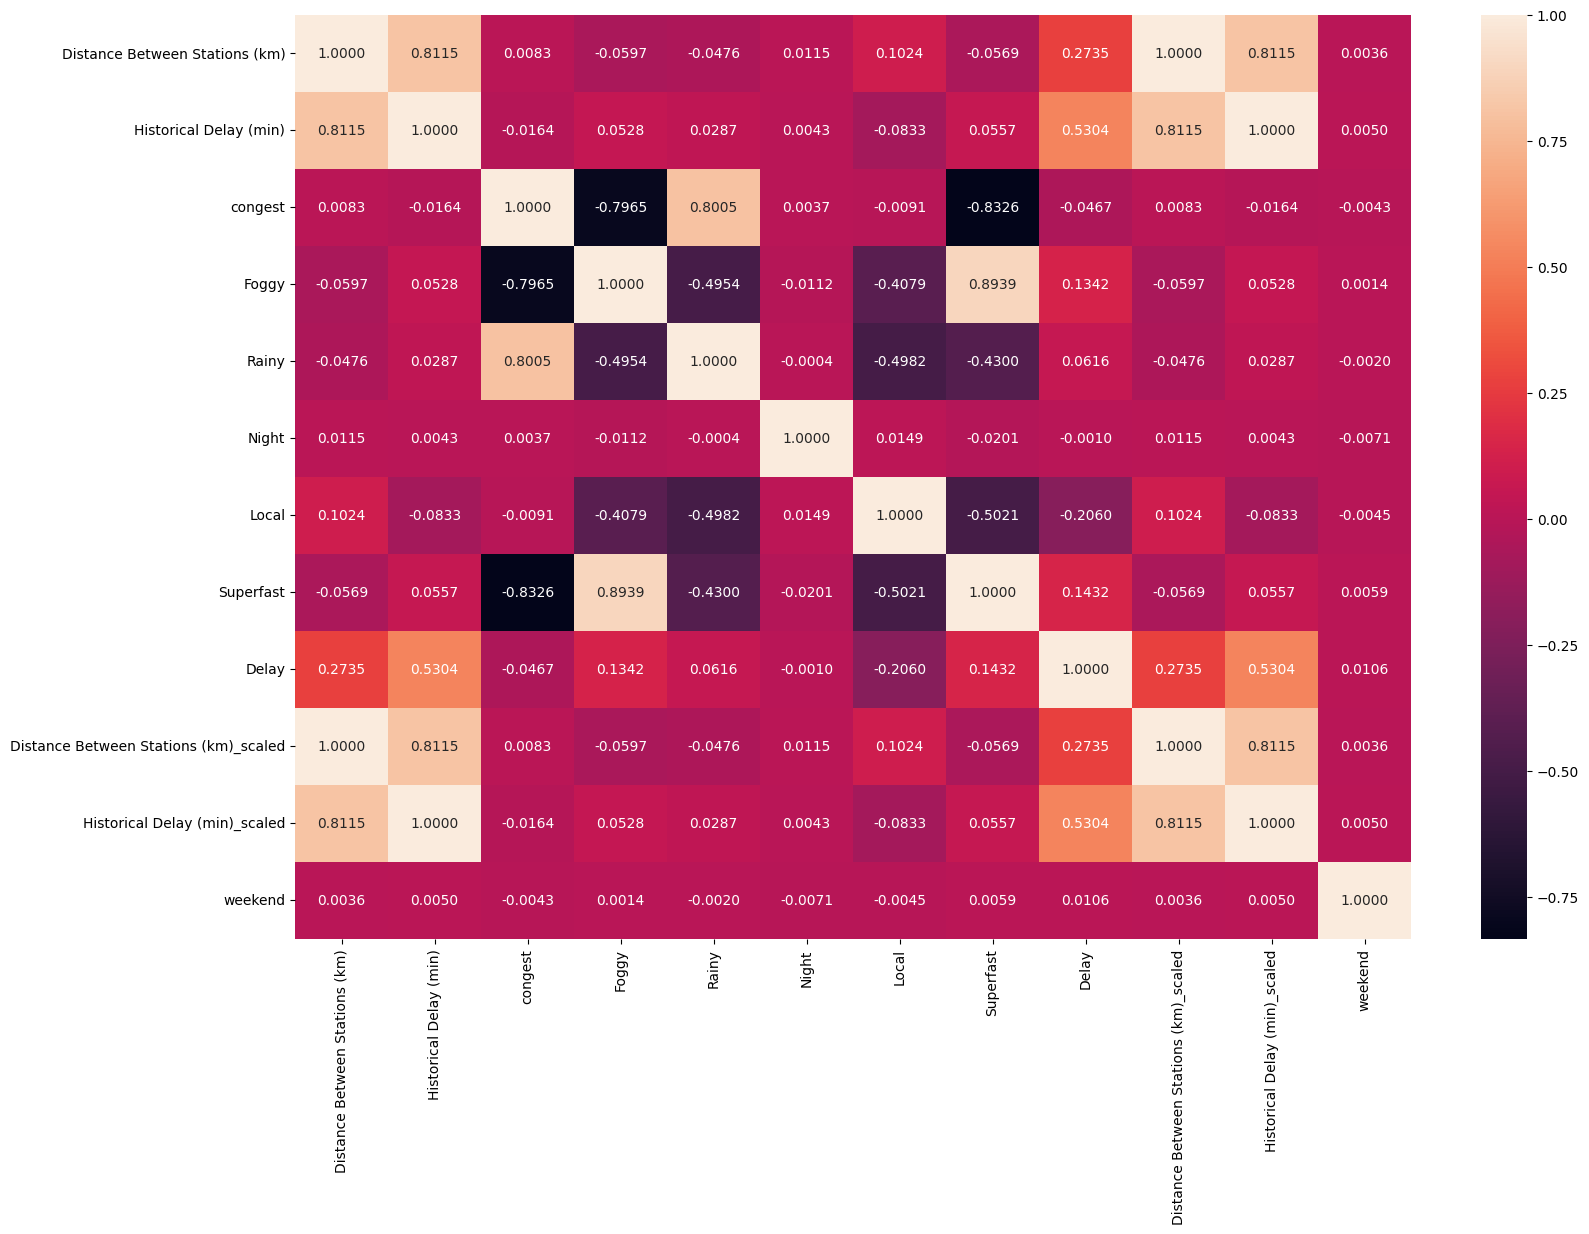

In [61]:
plt.figure(figsize=(18, 12))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".4f")
plt.show()

Decidim convertir els dies de la setmana en una única variable que indica si es tracta d'un dia entre setmana o en cap de setmana, i eliminem les variables "Morning" i "Evening", però deixem "Night" per indicar si és de dia o de nit. D'aquesta forma, reduïm el model sense perdre massa informació.

#### Models

In [62]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Delay'])